# Multiclass Classification

## Prepare the Dataset

In [1]:
import sklearn.datasets

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

np.random.seed(1)

iris = sklearn.datasets.load_iris()

# Scale our features
iris.data = StandardScaler().fit_transform(iris.data)

# Generate random indices to sample for our testing array
test_idx = np.random.randint(low=0, high=140, size=20)
train_idx = [x for x in range(150) if x not in test_idx]

X_train = iris.data[train_idx, :]
Y_train = iris.target[train_idx]

X_test = iris.data[test_idx, :]
Y_test = iris.target[test_idx]

## Reference Network (pyTorch)

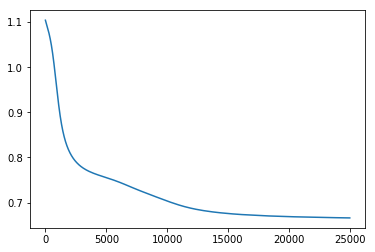

Time taken: 0:00:06.977925


In [2]:
import torch
from torch import nn
from torch import optim
from torch import tensor

torch.manual_seed(1)

tss = datetime.now()

# Create Tensors to hold inputs and outputs
x = tensor(X_train).type(torch.float)
y = tensor(Y_train).type(torch.long)

# Use the nn package to a basic model and multiclass cross entropy loss function.
model = nn.Sequential(
    nn.Linear(4, 10),
    nn.Tanh(),
    nn.Linear(10, 10),
    nn.Tanh(),
    nn.Linear(10, 3),
    nn.Sigmoid()
)

loss_fn = nn.CrossEntropyLoss()

# Use the optim package to define an SGD Optimizer that will update the weights of
# the model for us.
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
costs = []

# Initialise the model parameters as a uniform normal distribution
for layer in model:
    if layer.type == nn.Linear:
        layer.weight = nn.init.normal_(layer.weight)

# Train for 25,000 epochs.
for t in range(25000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    cost = loss_fn(y_pred, y)
    costs.append(cost.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    cost.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

# Plot the cost over training.
plt.plot(costs)
plt.show()

print('Time taken: {}'.format(datetime.now() - tss))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       0.64      1.00      0.78         9
          2       1.00      0.29      0.44         7

avg / total       0.84      0.75      0.71        20



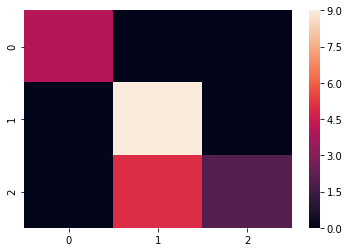

In [3]:
# Test the results
_, y_pred = torch.max(nn.Softmax(dim=1)(model(tensor(X_test).type(torch.float))), 1)

print(classification_report(Y_test, y_pred))
sns.heatmap(confusion_matrix(Y_test, y_pred))
plt.show()

## Potatolemon

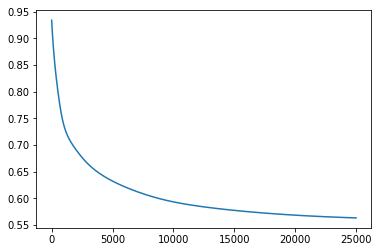

Time taken: 0:00:26.456118


In [4]:
import sys
sys.path.insert(0, '../')

from src import network

tss = datetime.now()

# Set up our network, specifying input dimensions and hidden layers
plnn = network.Network(4, [10, 10], num_classes=3, learning_rate=0.01,
                       activation=network.tanh,
                       loss=network.categorical_crossentropy)

# Initialise layer weights using a random uniform scheme
for layer in plnn.layers:
    layer.set_weights(np.random.standard_normal(layer.get_weights().shape))

# One-hot encode the Y-values
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
Y_train_oh = ohe.fit_transform(Y_train.reshape(-1, 1))

# Fit our network
costs = plnn.fit(X_train.T, Y_train_oh.T, epochs=25000, verbose=False)

# Plot the costs
plt.plot(costs)
plt.show()

print('Time taken: {}'.format(datetime.now() - tss))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         4
          1       0.73      0.89      0.80         9
          2       0.80      0.57      0.67         7

avg / total       0.81      0.80      0.79        20



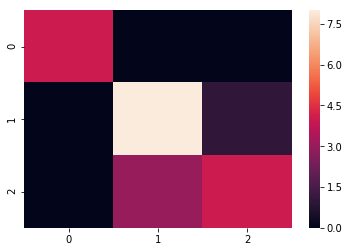

In [5]:
# Test the results
y_pred = plnn.predict(X_test.T)

print(classification_report(Y_test, y_pred))
sns.heatmap(confusion_matrix(Y_test, y_pred))
plt.show()